# Movie Recommendation using the MovieLens 20M dataset



The MovieLens 20M dataset contains over 20M ratings. Each row is a rating of a movie given by a user. The users usually only watched a very small portion of all the movies. A recommender system is to recommend movies in this case to a specific user so that the user will very likely rate high scores for the recommended movies.  

In this Notebook, I implemented KNN based collaborative filtering and matrix factorization algorith from scratch for movie recommendation.  In another Notebook, I used TensorFlow to build different neural netwoks to do the collaborative filtering.

### Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("rating.csv")

In [3]:
df.shape

(20000263, 4)

In [4]:
df.nunique()

userId         138493
movieId         26744
rating             10
timestamp    15351121
dtype: int64

There are 138493 unique user IDs and 26744 unique movie IDs.

In [5]:
df.apply([min, max])

,userId,movieId,rating,timestamp
min,1,1,0.5,1995-01-09 11:46:44
max,138493,131262,5.0,2015-03-31 06:40:02


- There are 138493 users with userId from 1 to 138493.
- There are 26744 movies with movieId ranging from 1 to 131262.

In [6]:
df.drop("timestamp", axis=1, inplace=True)

In [7]:
df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [8]:
# check how many movies each user rated
movies_per_user = (
    df.groupby("userId", as_index=False)["movieId"]
    .count()
    .rename(columns={"movieId": "total_movies"})
    .sort_values("total_movies", ascending=False)
)

Show the top 50 users who rated most number of movies

In [9]:
movies_per_user.head(50)

,userId,total_movies
118204,118205,9254
8404,8405,7515
82417,82418,5646
121534,121535,5520
125793,125794,5491
74141,74142,5447
34575,34576,5356
131903,131904,5330
83089,83090,5169
59476,59477,4988


Check the distribution of number of movies rated by each user.

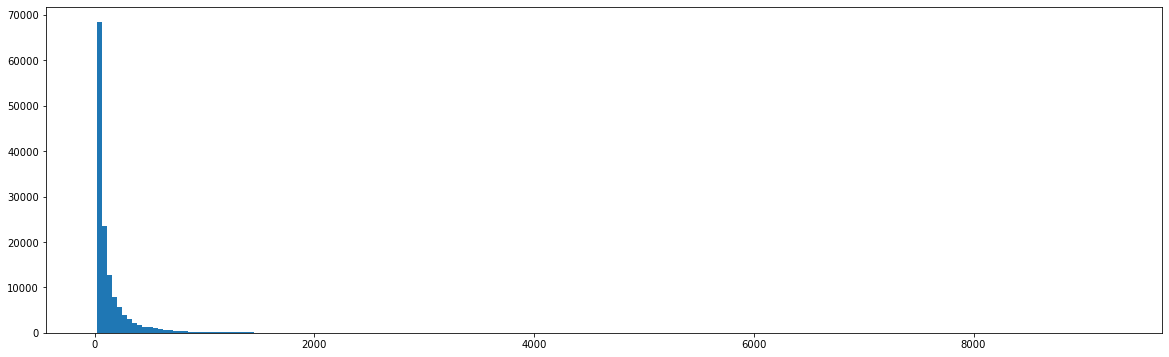

In [10]:
plt.figure(figsize=(20,6))
plt.hist(movies_per_user["total_movies"], 200)
plt.show()

Most of the users only rated a small number of movies. The figure below shows the users who rated less than 1000 movies.

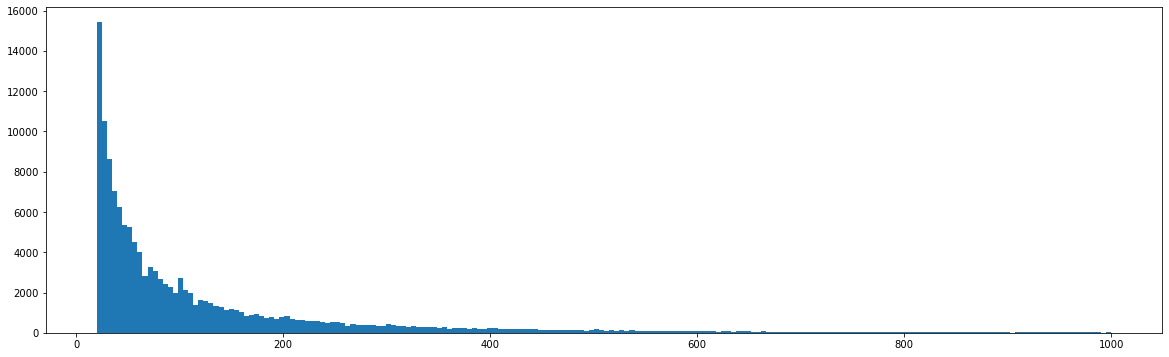

In [11]:
plt.figure(figsize=(20,6))
plt.hist(movies_per_user.loc[movies_per_user["total_movies"]<=1000, "total_movies"], 200)
plt.show()

In [12]:
# check the number of reviewers for each movie
users_per_movie = (
    df.groupby("movieId", as_index=False)["userId"]
    .count()
    .rename(columns={"userId": "total_users"})
    .sort_values("total_users", ascending=False)
)

Show top 50 movies that are rated by most number of users.

In [13]:
users_per_movie.head(50)

,movieId,total_users
293,296,67310
352,356,66172
315,318,63366
587,593,63299
476,480,59715
257,260,54502
108,110,53769
583,589,52244
2486,2571,51334
523,527,50054


Check the distribution of number of reviewers for each movie.

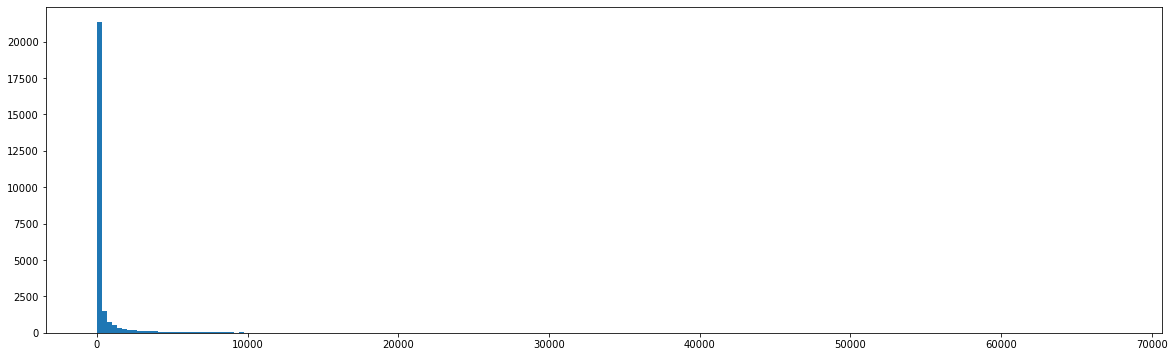

In [14]:
plt.figure(figsize=(20,6))
plt.hist(users_per_movie["total_users"], 200)
plt.show()

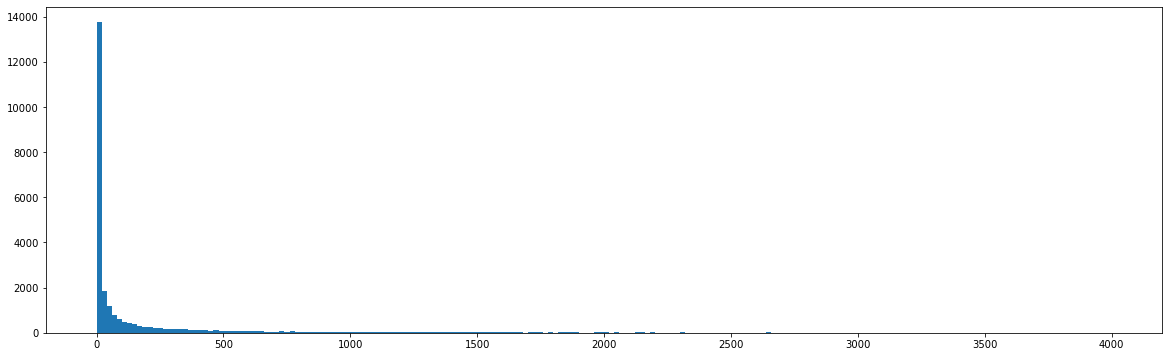

In [15]:
plt.figure(figsize=(20,6))
plt.hist(users_per_movie.loc[users_per_movie["total_users"]<=4000,"total_users"], 200)
plt.show()

### Data preparation

To save the computation time while demonstrating the concept, I made a smaller dataset by keeping a small number of users and movies.

In [16]:
# keep smaller numbers of users and movies 
n = 500
m = 200

In [17]:
user_ids = movies_per_user.iloc[:n, 0]
movie_ids = users_per_movie.iloc[:m, 0]

In [18]:
sm_df = df[df["userId"].isin(user_ids) & df["movieId"].isin(movie_ids)].copy()
sm_df.to_csv("small_rating.csv")
sm_df = pd.read_csv("small_rating.csv", index_col=0)

In [19]:
from sklearn.utils import shuffle

In [20]:
# split train test data set
train_size = int(0.8 * sm_df.shape[0])
sm_df_shuffled = shuffle(sm_df, random_state=1)
train_df = sm_df_shuffled[:train_size]
test_df = sm_df_shuffled[train_size:]
print(f"the size of the train dataset is {train_df.shape[0]}")
print(f"the size of the test dataset is {test_df.shape[0]}")

the size of the train dataset is 69212
the size of the test dataset is 17304


In [21]:
sm_df.head()

,userId,movieId,rating
19846,156,1,5.0
19847,156,2,5.0
19851,156,6,4.0
19854,156,10,4.0
19855,156,11,5.0


### Implement user-based and item-based k-nearest neighbor collaborative filtering

In [22]:
from scipy.sparse import csr_matrix
from sortedcontainers import SortedList

In [23]:

class CollaborativeFiltering:
    def __init__(self, k_neighbor=25, method = "user"):
        self.k_neighbor = k_neighbor
        # we can use user-based or item-based collaborative filtering
        self.method = method
        # list of user ID ordered from small to large
        self.userIds = None
        # list of movie Id ordered from small to large
        self.movieIds = None
        # number of users
        self.N = 0
        # number of movies
        self.M = 0
        # store the training DataFrame
        self.train_df = None
        # dictionary storing set of users who rated a movie. Key is movie ID, value is set of user IDs
        self.user_set_for_movie = None
        # dictionary storing set of movies rated by a user. Key is user ID, value is set of movie IDs
        self.movie_set_for_user = None
        # Dictionary storing the rating of user i and movie j. Key is tuple of (user i, movie j), value is rating
        self.rating_dict = None
        # average rating of all the movies given by one user
        self.ri_bar = None
        # average rating of a movie given by all users
        self.rj_bar = None
        # similarity matrix storing the weight between a user and any other users
        self.user_neighbors = {}
        # similarity matrix storing the weight between a movie and any other movies
        self.item_neighbors = {}

    
    def user_weight_cal(self, userId_i, userId_j):
        # get the rating of all movies for users i and j
        # r_i = np.array([self.rating_dict[(userId_i, movie)] for movie in self.movie_set_for_user[userId_i]])
        # r_j = np.array([self.rating_dict[(userId_j, movie)] for movie in self.movie_set_for_user[userId_j]])
        # find the common movies rated by both users i and j
        common_movies = list(set.intersection(self.movie_set_for_user[userId_i], self.movie_set_for_user[userId_j]))
        r_i_common = np.array([self.rating_dict[(userId_i, movie)] for movie in common_movies])
        r_j_common = np.array([self.rating_dict[(userId_j, movie)] for movie in common_movies])
        # if the number of common movies is not greater than 5, no need to calculate similarity
        # else use the ratings of common movies to calculate the weight
        if len(common_movies) <= 5:
            return None
        else:
            cm_dev_i = r_i_common - self.ri_bar[userId_i]
            cm_dev_j = r_j_common - self.ri_bar[userId_j]
            return np.dot(cm_dev_i, cm_dev_j) / np.sqrt(cm_dev_i.dot(cm_dev_i)) / np.sqrt(cm_dev_j.dot(cm_dev_j))

    def item_weight_cal(self, movieId_i, movieId_j):
        # find the common users who rated both movie i and j
        common_users = list(set.intersection(self.user_set_for_movie[movieId_i], self.user_set_for_movie[movieId_j]))
        r_i_common = np.array([self.rating_dict[(user, movieId_i)] for user in common_users])
        r_j_common = np.array([self.rating_dict[(user, movieId_j)] for user in common_users])
        if len(common_users) <= 5:
            return None
        else:
            cm_dev_i = r_i_common - self.rj_bar[movieId_i]
            cm_dev_j = r_j_common - self.rj_bar[movieId_j]
            return np.dot(cm_dev_i, cm_dev_j) / np.sqrt(cm_dev_i.dot(cm_dev_i)) / np.sqrt(cm_dev_j.dot(cm_dev_j))

    def find_user_neighbors(self):
        # find the k nearest neighbors for each user
        # save the pair of (negative weight, user index) in a list
        for i in self.userIds:
            sl = SortedList()
            for i_prime in self.userIds:
                if i != i_prime:
                    w_ii = self.user_weight_cal(i, i_prime)
                    if w_ii is not None:
                        sl.add((-w_ii, i_prime))
                        if len(sl) > self.k_neighbor:
                            del sl[-1]
            self.user_neighbors[i] = sl
        return None

    def find_item_neighbors(self):
        # find the k nearest neighbors for each movie
        # save the pair of (negative weight, movie ID) in a list
        for j in self.movieIds:
            sl = SortedList()
            for j_prime in self.movieIds:
                if j != j_prime:
                    w_jj = self.item_weight_cal(j, j_prime)
                    if w_jj is not None:
                        sl.add((-w_jj, j_prime))
                        if len(sl) > self.k_neighbor:
                            del sl[-1]
            self.item_neighbors[j] = sl
        return None

    def train(self, train_df):
        self.userIds = sorted(train_df["userId"].unique())
        self.movieIds = sorted(train_df["movieId"].unique())
        self.N = len(self.userIds)
        self.M = len(self.movieIds)
        self.train_df = train_df.copy()
        # create the set of users for each movie and set of movies for each user
        self.user_set_for_movie = self.train_df.groupby("movieId")["userId"].agg(set).to_dict()
        self.movie_set_for_user = self.train_df.groupby("userId")["movieId"].agg(set).to_dict()
        # create a sparse matrix for quick access of the ration for user i and movie j
        self.rating_dict = self.train_df.groupby(["userId", "movieId"])["rating"].first().to_dict()
        # store the average rating of movies for each user
        self.ri_bar = self.train_df.groupby("userId")["rating"].mean().to_dict()
        # store the average rating of a movie cross all users
        self.rj_bar = self.train_df.groupby("movieId")["rating"].mean().to_dict()
        if self.method == "user":
            self.find_user_neighbors()
        elif self.method == "item":
            self.find_item_neighbors()
        else:
            print("method is not defined. It should be 'user' or 'item'. ")
        return None
    
    # function to predict the rating that user i gaves to movie j
    def calculate_score_ij(self, user_i, movie_j):
        sum_weighted_dev = 0
        sum_abs_weight = 0
        if self.method == "user":
            # user-based collaborative filtering
            for w_ii, i_prime in self.user_neighbors[user_i]:
                # if closest neighbors have rated movie j, use weighted average to estimate the rating of user i on movie j
                if movie_j in self.movie_set_for_user[i_prime]:
                    sum_weighted_dev += -w_ii * (self.rating_dict[(i_prime, movie_j)] - self.ri_bar[i_prime])
                    sum_abs_weight += abs(w_ii)
            
            if sum_abs_weight == 0:
                prediction = self.ri_bar[user_i]
            else:
                prediction =  self.ri_bar[user_i] + sum_weighted_dev / sum_abs_weight
        elif self.method == "item":
            # item_based collaborative filtering
            for w_jj, j_prime in self.item_neighbors[movie_j]:
                if user_i in self.user_set_for_movie[j_prime]:
                    sum_weighted_dev += -w_jj * (self.rating_dict[(user_i, j_prime)] - self.rj_bar[j_prime])
                    sum_abs_weight += abs(w_jj)
            
            if sum_abs_weight == 0:
                prediction = self.rj_bar[movie_j]
            else:
                prediction = self.rj_bar[movie_j] + sum_weighted_dev / sum_abs_weight
        # make the prediction between 0.5 and 5
        prediction = min(5, prediction)
        prediction = max(0.5, prediction)
        return prediction
    
    def predict(self, users_arr, movies_arr):
        ratings = []
        for i, j in zip(users_arr, movies_arr):
            ratings.append(self.calculate_score_ij(i, j))

        return np.array(ratings)
    

User-based and item-based collaborative filtering are combined into one class as shown above.

In [24]:
# # impletement user-based collaborative filtering
# # use scipy.csr_matrix to store the user movie rating matrix

# class user_user_cf:
#     def __init__(self, k_neighbor=50):
#         self.k_neighbor = k_neighbor
#         # list of user IDs ordered from small to big. Used to map original IDs to new index ranging from 0 to N-1
#         self.userIds = None
#         # list of movie IDs ordered from small to big. Used to map original IDs to new index ranging from 0 to M-1
#         self.movieIds = None
#         self.N = 0
#         self.M = 0
#         # store the training DataFrame
#         self.train_df = None
#         # pd.Series storing set of users who rated a movie
#         self.user_set_for_movie = None
#         # pd.Series storing set of movies rated by a user
#         self.movie_set_for_user = None
#         # scipy.sparse.csr_matrix to store the user-movie rating table. Access the rating of user i gaving to movie j
#         self.rating_table = None
#         # average rating of all the movies given by one user
#         self.r_bar = None
#         # similarity matrix storing the weight between a user and any other users
#         self.neighbors = []
    
#     def weight_cal(self, userId_i, userId_j):
#         # get the rating of all movies for users i and j
#         r_i = self.rating_table.getrow(userId_i).toarray().squeeze()
#         r_j = self.rating_table.getrow(userId_j).toarray().squeeze()
#         # find the common movies rated by both users i and j
#         common_movies = list(set.intersection(self.movie_set_for_user[userId_i], self.movie_set_for_user[userId_j]))
#         # if the number of common movies is not greater than 5, no need to calculate similarity
#         # else use the ratings of common movies to calculate the weight
#         if len(common_movies) <= 5:
#             return None
#         else:
#             cm_dev_i = r_i[common_movies] - self.r_bar[userId_i]
#             cm_dev_j = r_j[common_movies] - self.r_bar[userId_j]
#             return np.dot(cm_dev_i, cm_dev_j) / np.sqrt(np.sum(cm_dev_i**2)) \
#             / np.sqrt(np.sum(cm_dev_j**2))

#     def find_neighbors(self):
#         # find the k nearest neighbors for each user
#         # save the pair of (negative weight, user index) in a list
#         for i in range(self.N):
#             sl = SortedList()
#             for i_prime in range(self.N):
#                 if i != i_prime:
#                     w_ii = self.weight_cal(i, i_prime)
#                     if w_ii is not None:
#                         sl.add((-w_ii, i_prime))
#                         if len(sl) > self.k_neighbor:
#                             del sl[-1]
#             self.neighbors.append(sl)
#         return None

#     def train(self, train_df):
#         self.userIds = sorted(train_df["userId"].unique())
#         self.movieIds = sorted(train_df["movieId"].unique())
#         self.N = len(self.userIds)
#         self.M = len(self.movieIds)
#         self.train_df = train_df.copy()
#         # map the original user IDs and movie IDs to new index
#         self.train_df["userId"] = train_df["userId"].map({v:i for i, v in enumerate(self.userIds)})
#         self.train_df["movieId"] = train_df["movieId"].map({v:i for i, v in enumerate(self.movieIds)})
#         # create the set of users for each movie and set of movies for each user
#         self.user_set_for_movie = self.train_df.groupby("movieId")["userId"].agg(set).to_dict()
#         self.movie_set_for_user = self.train_df.groupby("userId")["movieId"].agg(set).to_dict()
#         # create a sparse matrix for quick access of the ration for user i and movie j
#         self.rating_table = csr_matrix((self.train_df["rating"], (self.train_df["userId"], self.train_df["movieId"])), shape=(self.N, self.M))
#         # store the average rating of movies for each user
#         self.r_bar = self.train_df.groupby("userId")["rating"].mean().to_dict()

#         self.find_neighbors()
#         return None
    
#     # function to predict the rating that user i gaves to movie j
#     def calculate_score_ij(self, user_i, movie_j):
#         sum_weighted_dev = 0
#         sum_abs_weight = 0
#         for w_ii, i_prime in self.neighbors[user_i]:
#             # if closest neighbors have rated movie j, use weighted average to estimate the rating of user i on movie j
#             if movie_j in self.movie_set_for_user[i_prime]:
#                 sum_weighted_dev += -w_ii * (self.rating_table[i_prime, movie_j] - self.r_bar[i_prime])
#                 sum_abs_weight += abs(w_ii)
        
#         prediction =  self.r_bar[user_i] + sum_weighted_dev / sum_abs_weight
#         # make the prediction between 0.5 and 5
#         prediction = min(5, prediction)
#         prediction = max(0.5, prediction)
#         return prediction
    
#     def predict(self, users_arr, movies_arr):
#         users_arr = pd.Series(users_arr).map({v:i for i, v in enumerate(self.userIds)}).to_numpy()
#         movies_arr = pd.Series(movies_arr).map({v:i for i, v in enumerate(self.movieIds)}).to_numpy()
#         ratings = []
#         for i, j in zip(users_arr, movies_arr):
#             ratings.append(self.calculate_score_ij(i, j))

#         return np.array(ratings)
    

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
# calculate mean squared error
def mse(p, t):
  p = np.array(p)
  t = np.array(t)
  return np.mean((p - t)**2)
  

In [27]:
cf = CollaborativeFiltering(method="item")
cf.train(train_df)

In [28]:
pred_scores = cf.predict(test_df["userId"], test_df["movieId"])
print("MSE of test set is {}".format(mean_squared_error(pred_scores, test_df["rating"])))
print("Calculate MSE with self defined function: {}".format(mse(pred_scores, test_df["rating"])))

MSE of test set is 0.573039519370906
Calculate MSE with self defined function: 0.573039519370906


In [29]:
pred_scores[:20]

array([3.8820034 , 3.04782951, 3.43146611, 4.05259422, 2.83151329,
       3.1490208 , 4.38943653, 3.93509333, 4.11848969, 4.39462656,
       3.41518654, 4.24904875, 4.33686593, 3.67468392, 3.90805083,
       3.7093383 , 3.36917581, 4.19789522, 4.18694608, 3.04289707])

In [30]:
train_pred = cf.predict(train_df["userId"], train_df["movieId"])

In [31]:
print("MAE on train dataset is {}".format(mean_squared_error(train_pred, train_df["rating"])))

MAE on train dataset is 0.48798590313309814


In [32]:
test_df = test_df.assign(rating_pred = pred_scores).assign(residual = lambda df: df['rating_pred'] - df['rating'])
test_df.head()

,userId,movieId,rating,rating_pred,residual
3394509,23173,1196,4.0,3.882003,-0.117997
16421268,113668,2012,4.0,3.047830,-0.952170
13197608,91193,17,4.0,3.431466,-0.568534
8600975,59414,2959,4.5,4.052594,-0.447406
13785003,95254,36,4.5,2.831513,-1.668487


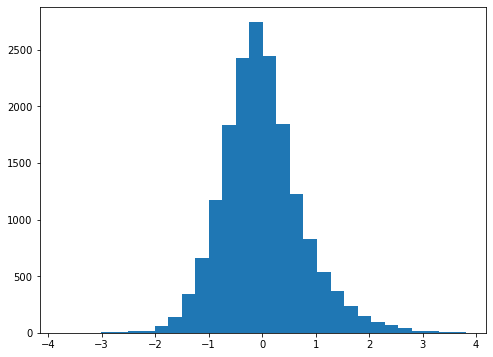

In [33]:
plt.figure(figsize=(8,6))
plt.hist(test_df['residual'], bins=30)
plt.show()

### Implement the matrix factorization algorith

In [34]:
# matrix factorization 

class MatrixFactorization:
    def __init__(self, k=10):
        self.k = k
        self.N = None
        self.M = None
        self.W = None
        self.U = None
        self.bi = None
        self.cj = None
        self.mu = None
        self.train_df = None
        self.userIds = None
        self.movieIds = None
        self.rating_dict = None
        self.movie_set_for_user = None
        self.user_set_for_movie = None

    # calculate the loss for the training dataset. It is squared error
    def loss(self):
        loss = 0
        for i,j in self.rating_dict.keys():
            loss += (self.rating_dict[(i,j)] - np.dot(self.W[i,:], self.U[:,j]) - self.bi[i] - self.cj[j] - self.mu) ** 2
        return loss

    def update_W(self):
        for i in range(self.N):
            uj_outer_sum = np.zeros((self.k, self.k))
            weighted_uj_sum = np.zeros(self.k)
            for j in self.movie_set_for_user[i]:
                uj = self.U[:,j]
                uj_outer_sum += np.outer(uj, uj)
                weighted_uj_sum += (self.rating_dict[(i,j)] - self.bi[i] - self.cj[j] - self.mu) * uj
            self.W[i,:] = np.linalg.solve(uj_outer_sum, weighted_uj_sum)
        return None

    def update_U(self):
        for j in range(self.M):
            wi_outer_sum = np.zeros((self.k, self.k))
            weighted_wi_sum = np.zeros(self.k)
            for i in self.user_set_for_movie[j]:
                wi = self.W[i,:]
                wi_outer_sum += np.outer(wi, wi)
                weighted_wi_sum += (self.rating_dict[(i,j)] - self.bi[i] - self.cj[j] - self.mu) * wi
            self.U[:, j] = np.linalg.solve(wi_outer_sum, weighted_wi_sum)
        return None
    
    def update_bi(self):
        for i in range(self.N):
            total = 0
            for j in self.movie_set_for_user[i]:
                total += self.rating_dict[(i,j)] - np.dot(self.W[i,:], self.U[:,j]) - self.cj[j] - self.mu
            self.bi[i] = total/len(self.movie_set_for_user[i])

        return None
    
    def update_cj(self):
        for j in range(self.M):
            total  = 0
            for i in self.user_set_for_movie[j]:
                total += self.rating_dict[(i,j)] - np.dot(self.W[i,:], self.U[:,j]) - self.bi[i] - self.mu
            self.cj[j] = total/len(self.user_set_for_movie[j])
        
        return None

    def train(self, train_df):
        self.userIds = sorted(train_df["userId"].unique())
        self.movieIds = sorted(train_df["movieId"].unique())
        self.N = len(self.userIds)
        self.M = len(self.movieIds)
        self.train_df = train_df.copy()
        # map the original user IDs and movie IDs to new index
        self.train_df["userId"] = train_df["userId"].map({v:i for i, v in enumerate(self.userIds)})
        self.train_df["movieId"] = train_df["movieId"].map({v:i for i, v in enumerate(self.movieIds)})
        # create the set of users for each movie and set of movies for each user
        self.user_set_for_movie = self.train_df.groupby("movieId")["userId"].agg(set).to_dict()
        self.movie_set_for_user = self.train_df.groupby("userId")["movieId"].agg(set).to_dict()
        self.rating_dict = self.train_df.groupby(["userId", "movieId"])["rating"].first().to_dict()
        self.mu = self.train_df["rating"].mean()

        # initialize the parameters randomly
        self.W = np.random.random((self.N, self.k))
        self.U = np.random.random((self.k, self.M))
        self.bi = np.random.random(self.N)
        self.cj = np.random.random(self.M)
        print("initialization....")
        # train model
        prev_loss = np.Infinity
        curr_loss = self.loss()
        while prev_loss - curr_loss > 3:
            prev_loss = curr_loss
            self.update_W()
            self.update_U()
            self.update_bi()
            self.update_cj()
            curr_loss = self.loss()
            print(curr_loss)
        
        return None

    def estimateRating(self, i, j):
        return np.dot(self.W[i,:], self.U[:,j]) + self.bi[i] + self.cj[j] + self.mu

    def predict(self, userIdArr, movieIdArr):
        # map the original IDs to new IDs
        userIdArr = pd.Series(userIdArr).map({v:i for i, v in enumerate(self.userIds)}).to_numpy()
        movieIdArr = pd.Series(movieIdArr).map({v:i for i, v in enumerate(self.movieIds)}).to_numpy()
        ratings = []
        for i, j in zip(userIdArr, movieIdArr):
            ratings.append(self.estimateRating(i,j))
        return np.array(ratings)

        

Use matrix calculation instead of loops

In [35]:
# matrix factorization using matrix calculation instead of loop

class MatrixFactorization2:
    def __init__(self, k=10):
        self.k = k
        self.N = None
        self.M = None
        self.W = None
        self.U = None
        self.bi = None
        self.cj = None
        self.mu = None
        self.train_df = None
        self.userIds = None
        self.movieIds = None
        self.rating_dict = None
        self.movie_set_for_user = None
        self.user_set_for_movie = None
        self.rating_for_user = None
        self.rating_for_movie = None

    # calculate the loss for the training dataset. It is squared error
    def loss(self):
        loss = 0
        for i,j in self.rating_dict.keys():
            loss += (self.rating_dict[(i,j)] - np.dot(self.W[i,:], self.U[:,j]) - self.bi[i] - self.cj[j] - self.mu) ** 2
        return loss

    def one_update(self):
        # update W
        for i in range(self.N):
            selected_movie_idx = list(self.movie_set_for_user[i])
            p = len(selected_movie_idx)
            # (k, p) matrix
            uj = self.U[:,selected_movie_idx]
            dev_j = self.rating_for_user[i] - self.bi[i] - self.cj[selected_movie_idx] - self.mu
            # dev_j = np.array([self.rating_dict[(i, x)] - self.bi[i] - self.cj[x] - self.mu for x in selected_movie_idx])
            self.W[i,:] = np.linalg.solve(uj.dot(uj.T), uj.dot(dev_j))
            self.bi[i] = np.ones(p).dot(self.rating_for_user[i] - self.W[i,:].dot(uj) - self.cj[selected_movie_idx] - self.mu) / p

        # update U
        for j in range(self.M):
            selected_user_idx = list(self.user_set_for_movie[j])
            q = len(selected_user_idx)
            # (q, k) matrix
            wi = self.W[selected_user_idx, :]
            dev_i = self.rating_for_movie[j] - self.bi[selected_user_idx] - self.cj[j] - self.mu
            self.U[:,j] = np.linalg.solve(wi.T.dot(wi), wi.T.dot(dev_i))
            self.cj[j] = np.ones(q).dot(self.rating_for_movie[j] - wi.dot(self.U[:,j]) - self.bi[selected_user_idx] - self.mu) / q
        
        return None

    def train(self, train_df):
        self.userIds = sorted(train_df["userId"].unique())
        self.movieIds = sorted(train_df["movieId"].unique())
        self.N = len(self.userIds)
        self.M = len(self.movieIds)
        self.train_df = train_df.copy()
        # map the original user IDs and movie IDs to new index
        self.train_df["userId"] = train_df["userId"].map({v:i for i, v in enumerate(self.userIds)})
        self.train_df["movieId"] = train_df["movieId"].map({v:i for i, v in enumerate(self.movieIds)})
        # create the set of users for each movie and set of movies for each user
        self.user_set_for_movie = self.train_df.groupby("movieId")["userId"].agg(set).to_dict()
        self.movie_set_for_user = self.train_df.groupby("userId")["movieId"].agg(set).to_dict()
        self.rating_dict = self.train_df.groupby(["userId", "movieId"])["rating"].first().to_dict()
        self.rating_for_movie = {}
        for j, v in self.user_set_for_movie.items():
            self.rating_for_movie[j] = np.array([self.rating_dict[(i,j)] for i in v])
        self.rating_for_user  ={}
        for i, v in self.movie_set_for_user.items():
            self.rating_for_user[i] = np.array([self.rating_dict[(i,j)] for j in v])
        self.mu = self.train_df["rating"].mean()

        # initialize the parameters randomly
        self.W = np.random.random((self.N, self.k))
        self.U = np.random.random((self.k, self.M))
        self.bi = np.random.random(self.N)
        self.cj = np.random.random(self.M)
        print("initialization....")
        # train model
        prev_loss = np.Infinity
        curr_loss = self.loss()
        while prev_loss - curr_loss > 3:
            prev_loss = curr_loss
            self.one_update()
            curr_loss = self.loss()
            # print(curr_loss)
        print("Done.")
        return None

    def estimateRating(self, i, j):
        return np.dot(self.W[i,:], self.U[:,j]) + self.bi[i] + self.cj[j] + self.mu

    def predict(self, userIdArr, movieIdArr):
        # map the original IDs to new IDs
        userIdArr = pd.Series(userIdArr).map({v:i for i, v in enumerate(self.userIds)}).to_numpy()
        movieIdArr = pd.Series(movieIdArr).map({v:i for i, v in enumerate(self.movieIds)}).to_numpy()
        ratings = []
        for i, j in zip(userIdArr, movieIdArr):
            ratings.append(self.estimateRating(i,j))
        return np.array(ratings)

        

In [36]:
mf = MatrixFactorization2(k=8)
mf.train(train_df)

initialization....
Done.


In [37]:
test_pred = mf.predict(test_df["userId"], test_df["movieId"])

In [38]:
print("MAE of test set is {}".format(mean_squared_error(test_pred, test_df["rating"])))

MAE of test set is 0.5916479333737129


In [39]:
print("MAE of training set is {}".format(mean_squared_error(train_df["rating"], mf.predict(train_df["userId"], train_df["movieId"]))))

MAE of training set is 0.4452138015056747
